[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/v0.6.2/docs/cassegrain_ray_tracing_tutorial.ipynb)

![astrohack](_media/astrohack_logo.png)

# Cassegrain Ray Tracing tutorial
This tutorial was created to clarify the usage of the Cassegrain ray tracing tools.
These tools were created as a proof of concept of using ray tracing to simulate phase effects caused by small optical misalignments in holography apertures.
On previous holography experiments, e.g. VLA holographies, these phase effects were fitted out of apertures by using a phase model derived by Ruze (1969), this model assumes that the path length perturbations are small and hence only the first-degree terms are used.
This type of "phase fitting" is very powerful, however it relies on the misalignments being small and on the fact of the VLA using a modified version of the Cassegrain optical design.
For the case of the ngVLA this is no longer the case and both reflectors used shaped optics, and thus it is very hard to estimate phase effects on the aperture analytically.
Hence the need for a Ray tracing model of the ngVLA.

The toy model presented here is a proof of concept, that can be checked against the phase fitting algorithm already present in astrohack.

In [1]:
import os
try:
    import astrohack
    
    print('AstroHACK version', astrohack.__version__, 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', astrohack.__version__, ' installed.')

AstroHACK version 0.6.2 already installed.


## Setting up
In this step we create the variables containing the names of the files to be created, as well as the folder to contain the plots and ray tracing file.

In [2]:
# Setting up file names and a folder to contain data
datafolder = 'vla-rt-data'
os.makedirs(datafolder, exist_ok=True)
vla_rt_filename = datafolder+'/VLA-rt.zarr'
plot_base_names = datafolder+'/vla-rt'

## Initiate Telescope parameters
To run the ray tracing pipeline, we need a set of parameters to describe the optics of the telescope to be simulated.
The expected format for these parameters is a dictionary, the function below creates such a dictionary.
Below we fill the parameters of this function with the appropriate values for the VLA, according to EVLA memo 211.


In [3]:
from astrohack import create_ray_tracing_telescope_parameter_dict

vla_pars = create_ray_tracing_telescope_parameter_dict(
    primary_diameter = 25,        # 25 meters for the VLA
    secondary_diameter = 2.5146,  # VLA's Secondary diameter
    focal_length = 9.0,           # VLA's focal length
    z_intercept = 3.140,          # Distance between the z intercept of the secondary and the point between the 2 foci
    foci_half_distance = 3.662,   # Half distance between the 2 foci
    inner_radius = 2.0,           # Inner blockage
    horn_diameter = 0.2,          # Horn diameter
    length_unit = 'm'             # Unit for the dimensions given
)

print()
for key, item in vla_pars.items():
    print(f'{key:20s} = {item}')
print()

[2025-03-26 16:14:00,322]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 



primary_diameter     = 25.0
secondary_diameter   = 2.5146
focal_length         = 9.0
z_intercept          = 3.14
foci_half_distance   = 3.662
inner_radius         = 2.0
horn_diameter        = 0.2
horn_position        = [0, 0, 1.6760000000000002]
horn_orientation     = [0, 0, 1]



## Run Ray tracing pipeline
In the step below we ran the actual ray tracing pipeline.
By default, no perturbations are introduced, the user is encouraged to play with the parameters to see the effects they create on the phase image plotted on the next step.
Note that to first order a X Y displacement of the secondary reflector is equivalent to a pointing offset, a pointing offset is usually used to compensate for such displacements of the secondary, such as the ones caused by gravitational torques. Such is the case in reference pointing.

In [4]:
%%time
from astrohack import cassegrain_ray_tracing_pipeline

rt_xds = cassegrain_ray_tracing_pipeline(
        output_xds_filename = vla_rt_filename,  # Name of the output XDS file
        telescope_parameters = vla_pars,        # Using previously defined dictionary with VLA parameters
        grid_size = 28,                         # Big enough to fit the primary of the VLA with some spare
        grid_resolution = 0.1,                  # Fine grained enough for most holographies
        grid_unit = 'm',                        # Unit for grid parameters
        x_pointing_offset = 0,                  # Pointing offset in the X direction
        y_pointing_offset = 0,                  # Pointing offset in the Y direction
        pointing_offset_unit = 'asec',          # Unit for pointing offset
        x_focus_offset = 0,                     # Secondary displacement in the X direction
        y_focus_offset = 0,                     # Secondary displacement in the Y direction
        z_focus_offset = 0,                     # Secondary displacement in the Z direction (regular focus offset)
        focus_offset_unit = 'mm',               # Unit for secondary displacements
        phase_offset = 0,                       # Simple additive offset for phases
        phase_unit = 'deg',                     # Unit for phase offset
        observing_wavelength = 1,               # Wavelength for the simulations
        wavelength_unit = 'cm',                 # Unit for the wavelength
        overwrite = True                        # Overwrite RT file on disk
)

[2025-03-26 16:14:00,349]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


CPU times: user 4.93 s, sys: 67.9 ms, total: 5 s
Wall time: 4.93 s


The ray tracing pipeline produces at the end a Xarray dataset that is saved to disk on a Zarr format, this data product shall be called the `rt_xds` from now on.
The `rt_xds` is also returned as an Xarray dataset object that can be inspected.
Below we can that the data variables inside the `rt_xds` are not shaped as an image they are arrays of tridimensional points, arrays of tridimensional vectors or 1D arrays.
The data is arranged this way to minimize the overhead of checking for nans in images, and can be easily rebuilt onto a 2D image grid with the data variable `image_indexes`.

In [5]:
rt_xds

<xarray.Dataset> Size: 11MB
Dimensions:                        (points: 47816, xyz: 3, vxyz: 3, idx: 2,
                                    x: 283, y: 283)
Dimensions without coordinates: points, xyz, vxyz, idx, x, y
Data variables: (12/15)
    primary_points                 (points, xyz) float64 1MB -12.45 ... 4.336
    primary_normals                (points, vxyz) float64 1MB 0.5682 ... 0.8215
    image_indexes                  (points, idx) int64 765kB 16 130 ... 265 151
    x_axis                         (x) float64 2kB -14.05 -13.95 ... 14.05 14.15
    y_axis                         (y) float64 2kB -14.05 -13.95 ... 14.05 14.15
    primary_reflections            (points, vxyz) float64 1MB 0.9335 ... 0.3497
    ...                             ...
    secondary_normals              (points, vxyz) float64 1MB 0.5239 ... 0.8507
    secondary_reflections          (points, vxyz) float64 1MB 0.1059 ... -0.9943
    distance_secondary_to_horn     (points) float64 383kB 7.083 7.083 ... 7.083
    horn_intercept                 (points, xyz) float64 1MB -3.109e-14 ... 1...
    total_path                     (points) float64 383kB 19.62 19.62 ... 19.62
    phase                          (points) float64 383kB 0.08727 ... 0.08727
Attributes:
    image_size:            283
    npnt_1d:               47816
    telescope_parameters:  {'primary_diameter': 25.0, 'secondary_diameter': 2...
    input_parameters:      {'output_xds_filename': 'vla-rt-data/VLA-rt.zarr',...

## Plotting phases and other interesting products
Since the data variables in the `rt_xds` have to be gridded in order to be properly viewed a convenience function was created to allow easy access to its data variables.
The variables that can be accessed this way are the ones that have points as their first dimension, excepting image_indexes as it only contains the information needed to regrid the points to 2D images.

[2025-03-26 16:14:05,324]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


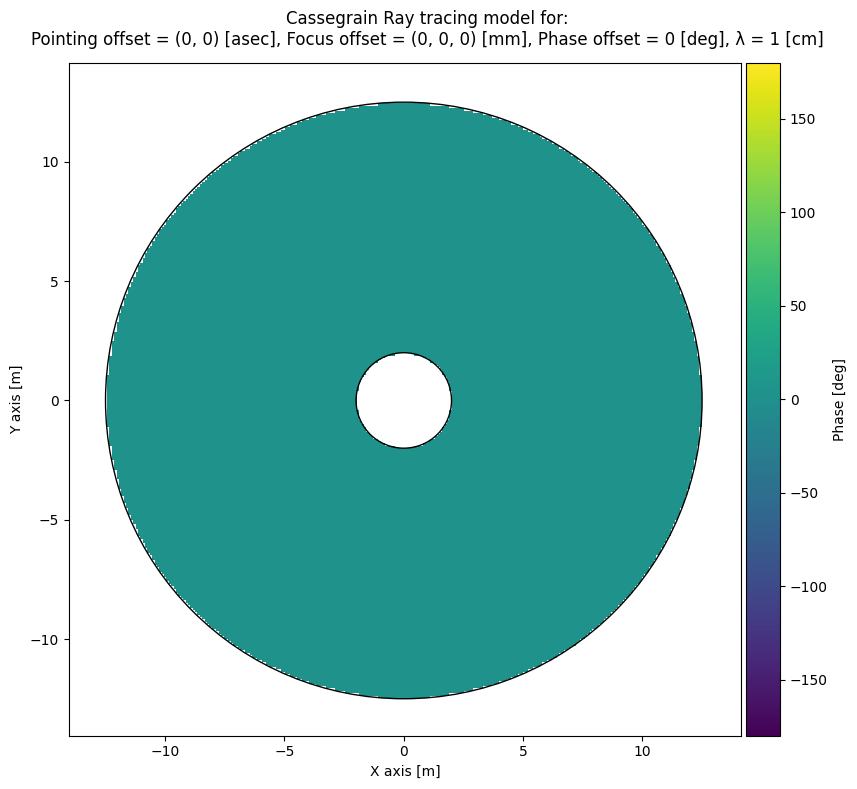

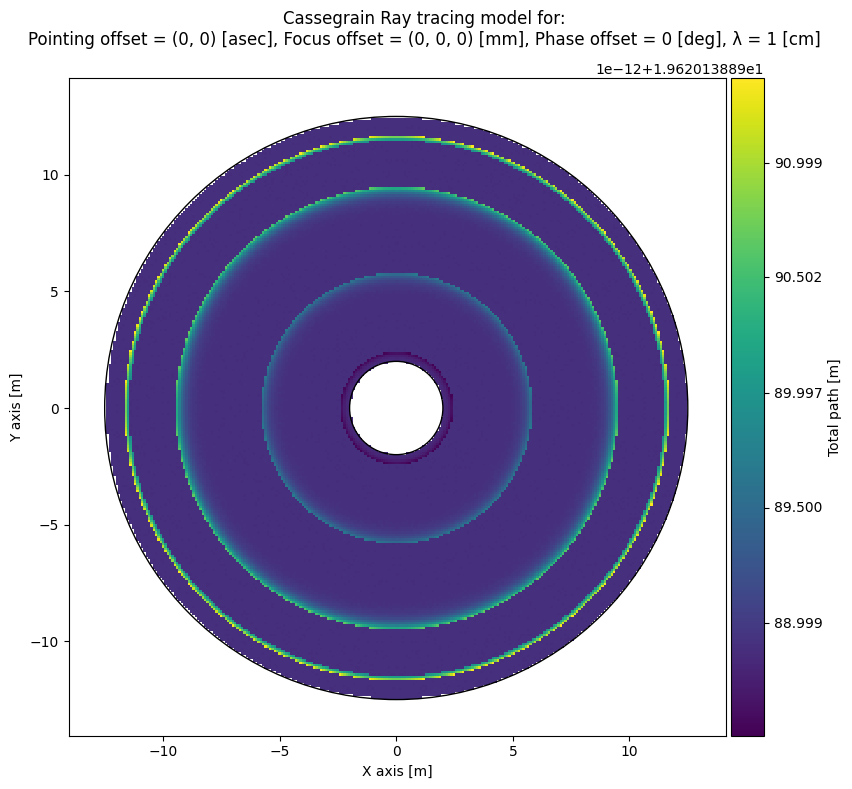

In [6]:
from astrohack import plot_2d_maps_from_rt_xds
plot_2d_maps_from_rt_xds(
        rt_xds_filename = vla_rt_filename,  # Name of the input XDS file with RT results
        keys = ['phase', 'total_path'],     # Keys to be plotted
        rootname = plot_base_names,         # Base name for plot files
        phase_unit = 'deg',                 # Unit for phase plots
        length_unit = 'm',                  # Unit for other available keys
        colormap = 'viridis',               # Colormap to be used in plots
        display = True,                     # Display plots below
        dpi = 300                           # Resolution for the png plots
)

## Radial projection plot
Another interesting visualization is the projection of the rays as seen from a cross section across the middle of the primary dish.
This allows us to track the path of rays from the sky and into the horn.
The user is encouraged to play with the ray tracing parameters and check when rays simply stop being detected at the horn.
It is also interesting to make this plot with nrays=0 to obtain a simplified schematic of the telescope's optical design.

[2025-03-26 16:14:08,430]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


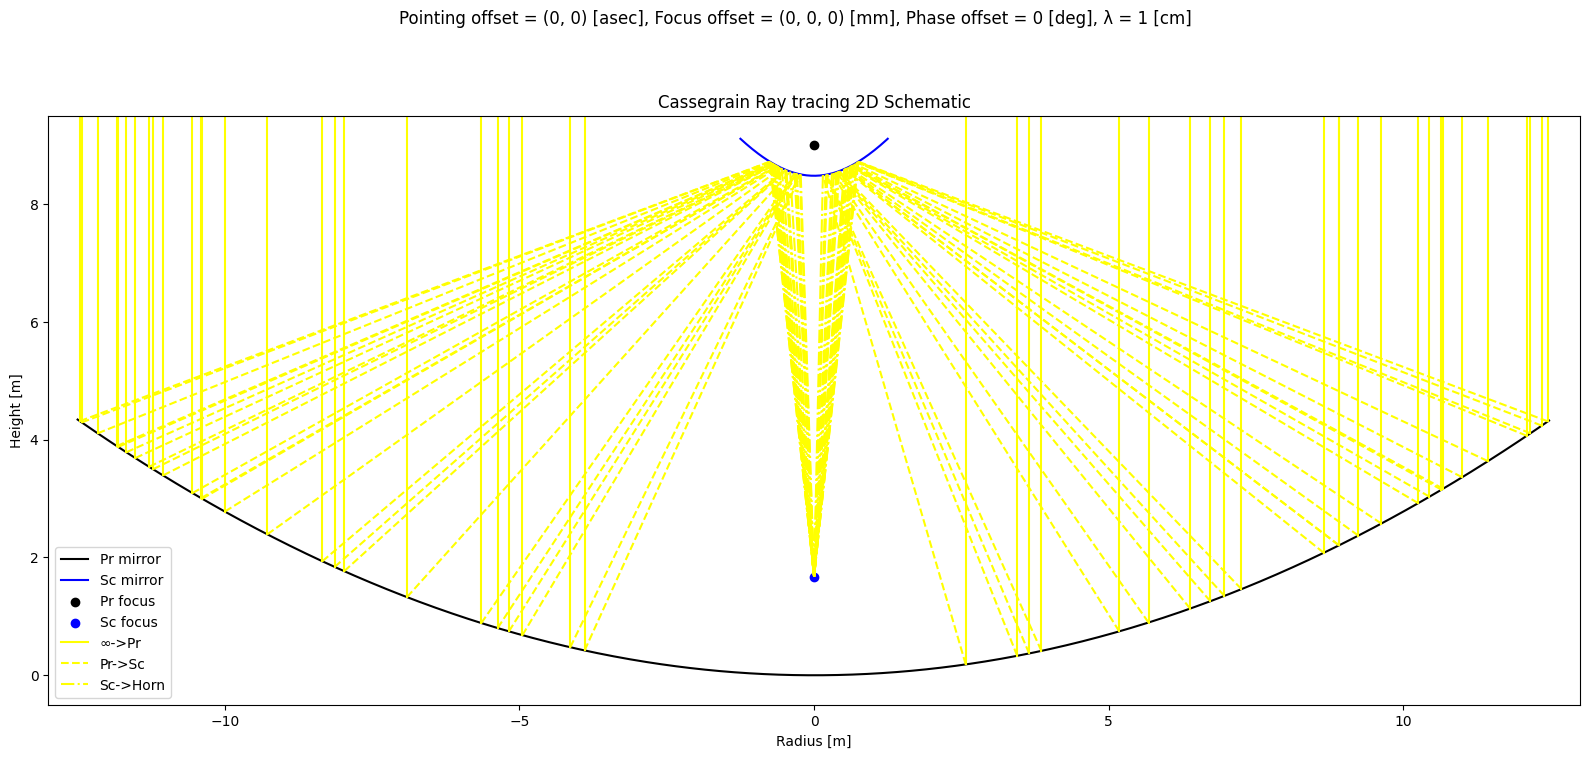

In [7]:
from astrohack import plot_radial_projection_from_rt_xds

plot_radial_projection_from_rt_xds(
        rt_xds_filename = vla_rt_filename,        # RT XDS filename
        plot_filename = plot_base_names+'rz.png', # Name of the file to be saved to disk with the plot
        nrays = 50,                                # No rays plotted here
        display = True,                           # Display plot below
        dpi = 300                                 # Resolution for the png plot
)

## Comparison to Astrohack's VLA phase fitting
Last but not least, we have a check against the phase fitting mechanism present in `astrohack.holog`.
For this analysis is important to understand that some phase effects are in fact degenerated with each other.
A Z offset of the secondary reflector creates a ringing effect on the phases but also a large phase offset, which makes the phase offset mildly degenerate with the focus offset, making it difficult to isolate one effect from the other.
Similarly, X & Y displacements of the secondary are degenerate with pointing offsets.
Hence if the user wants to check if a pointing offset is recovered by the phase fitting algorithm, they should set `fit_xy_secondary_offset` to False, and vice versa.
Unfortunately, it is not possible to do the same with the focus offset as it not possible to turn off the phase offset in the phase fitting algorithm.
It is also important to bear in mind that the phase fitting algorithm is not capable of fitting phase offsets larger than ~1 arc minute, or secondary offsets larger than ~3 mm.

[2025-03-26 16:14:10,233]     INFO   astrohack:  Module path: /home/victor/work/Holography-1022/astrohack/src/astrohack 


Comparison between input and fitted values
+----------------+----------------+-----------+-------------------------+------+
|   Parameter    |     Value      | Reference |        Difference       | unit |
+----------------+----------------+-----------+-------------------------+------+
|  Phase offset  |  0.061 ± 0.0   |    0.0    |   0.06089824191314005   | deg  |
| X point offset | -0.00041 ± 0.0 |     0     |  -0.0004121671808000489 | asec |
| Y point offset | -0.00042 ± 0.0 |     0     | -0.00041660382055965796 | asec |
| X focus offset | 0.000126 ± 0.0 |     0     |  0.00012591419987018515 |  mm  |
| Y focus offset | 0.000126 ± 0.0 |     0     |  0.0001256841894315438  |  mm  |
| Z focus offset |  0.056 ± 0.0   |     0     |    0.0564328874709479   |  mm  |
+----------------+----------------+-----------+-------------------------+------+




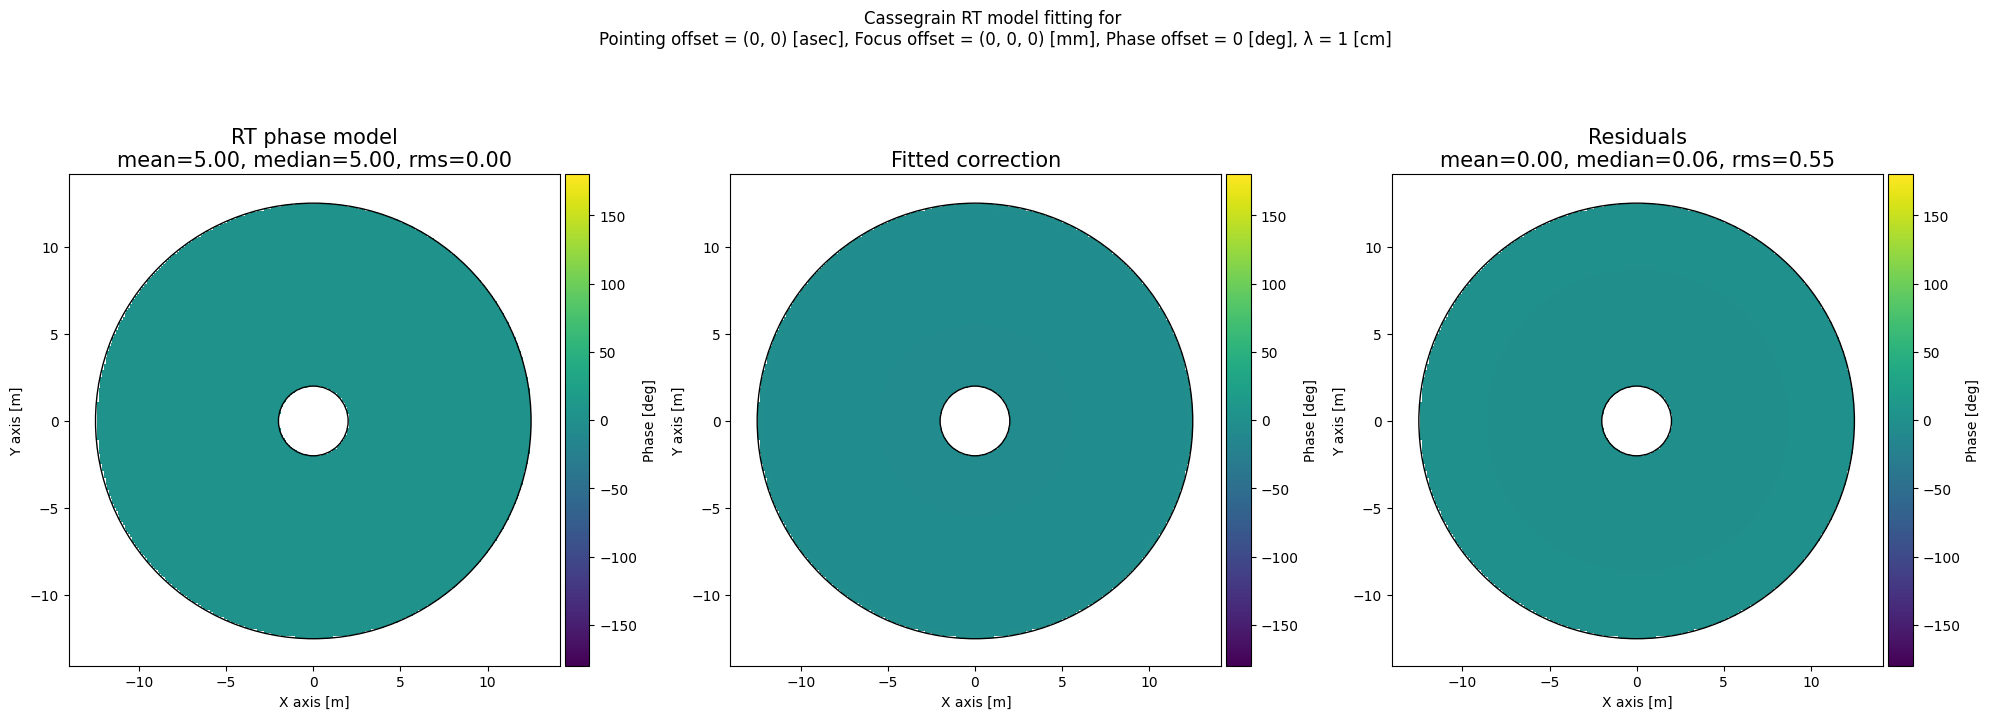

CPU times: user 5.14 s, sys: 896 ms, total: 6.03 s
Wall time: 4.82 s


In [8]:
%%time
from astrohack import apply_holog_phase_fitting_to_rt_xds

apply_holog_phase_fitting_to_rt_xds(
        rt_xds_filename = vla_rt_filename,                  # RT XDS filename
        phase_plot_filename = plot_base_names+'vs-fit.png', # Name of the file to be saved to disk with the phase comparison plot
        fit_pointing_offset = True,                         # Fit pointing offsets
        fit_xy_secondary_offset = True,                     # Fit secondary offsets in the X&Y directions
        fit_focus_offset = True,                            # Fit Z offsets of the secondary
        phase_unit = 'deg',                                 # Unit for phases in plots
        colormap = 'viridis',                               # Colormap for phase plots
        display = True,                                     # Display plot below
        dpi = 300                                           # Resolution for the png plot
)